In [1]:
import numpy as np

import dreamcoder as dc
from dreamcoder.domains.quantum_algorithms.primitives import *
from dreamcoder.domains.quantum_algorithms.tasks import *

import time
from tqdm import trange
import random

%autoreload 2
%load_ext line_profiler

UsageError: Line magic function `%autoreload` not found.


### Testing some circuits

In [2]:
n_qubit = 2
full_circuit = (n_qubit,
           (("cnot", 0, 1),
           ("swap", 0, 1),
           ("hadamard", 1))
)
full_circuit

(2, (('cnot', 0, 1), ('swap', 0, 1), ('hadamard', 1)))

In [3]:
tensor = eye(n_qubit)
tensor_to_mat(swap(cnot(tensor,0,1),0,1))

array([[1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.]], dtype=float16)

In [4]:
full_circuit_to_mat(full_circuit)

array([[ 0.707,  0.707,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.707,  0.707],
       [ 0.   ,  0.   ,  0.707, -0.707],
       [ 0.707, -0.707,  0.   ,  0.   ]], dtype=float16)

In [5]:
print_circuit(full_circuit)

                  
q_0: ──■───X──────
     ┌─┴─┐ │ ┌───┐
q_1: ┤ X ├─X─┤ H ├
     └───┘   └───┘


In [6]:
with QiskitTester(full_circuit) as QT:
    QT.circuit.cnot(QT.q(0),QT.q(1))
    QT.circuit.swap(QT.q(0),QT.q(1))
    QT.circuit.h(QT.q(1))
print(QT)
QT.check()

     ┌───┐   ┌───┐
q_0: ┤ X ├─X─┤ H ├
     └─┬─┘ │ └───┘
q_1: ──■───X──────
                  


Code consistent with Qiskit


In [7]:
n_qubit= 3
code = dc.program.Program.parse("(lambda (cnot (minv(mv $0))))")
code.infer()
code.evaluate([])(no_op(n_qubit))

((1, -1, 3), (('cnot', 1, 0),))

In [8]:
code.evaluate([])(no_op(n_qubit))

((1, -1, 3), (('cnot', 1, 0),))

In [9]:
state_circuit_to_mat(code.evaluate([])(no_op(n_qubit)))

array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.]], dtype=float16)

### Testing some Tasks

In [10]:
tasks = makeTasks()

In [11]:
task = get_task_from_name("hadamard_0",tasks)
code = dc.program.Program.parse("(lambda (h $0))")
task.logLikelihood(code),  grammar.logLikelihood(code.infer(), code)


(0.0, -4.1588830833596715)

In [12]:
task =get_task_from_name("cnot_01",tasks)
code = dc.program.Program.parse("(lambda (cnot $0))")
task.logLikelihood(code), grammar.logLikelihood(code.infer(), code)

(0.0, -4.1588830833596715)

In [13]:
task = get_task_from_name("cnot_10",tasks)
code = dc.program.Program.parse("(lambda (cnot (minv(mv $0))))")
task.logLikelihood(code),  grammar.logLikelihood(code.infer(), code)


(0.0, -8.317766166719343)

In [14]:
task = get_task_from_name("swap_01",tasks)
code = dc.program.Program.parse("(lambda  (cnot(minv(mv_r(cnot(minv (mv (cnot $0))))))))")
task.logLikelihood(code),  grammar.logLikelihood(code.infer(), code)


(0.0, -16.635532333438686)

In [15]:
code = dc.program.Program.parse("(lambda  (mv(mv(cnot(minv(mv_r(cnot(minv (mv (cnot $0))))))))))")
code.evaluate([])(no_op(3))


((2, 1, 3), (('cnot', 0, 1), ('cnot', 1, 0), ('cnot', 0, 1)))

In [16]:
# Testing embedding primitive
code = dc.program.Program.parse("(lambda (mv (emb (lambda  (mv(mv(cnot(minv(mv_r(cnot(minv (mv (cnot $0))))))))))  $0 )))")

code.evaluate([])(no_op(3))

((1, 1, 3), (('cnot', 0, 1), ('cnot', 1, 0), ('cnot', 0, 1)))

In [17]:
task = get_task_from_name("cz_01",tasks)
code = dc.program.Program.parse("(lambda (h(mv(cnot(mv_r(h (mv $0)))))))")
task.logLikelihood(code),  grammar.logLikelihood(code.infer(), code)
np.round(state_circuit_to_mat(code.evaluate([])(no_op(2))),decimals=2)

array([[ 1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  0., -1.]], dtype=float16)

In [18]:
with QiskitTester(code.evaluate([])(no_op(3))) as QT:
    QT.circuit.cz(QT.q(0),QT.q(1))
print(QT)
QT.check()
np.real(np.array(QT.result))

        
q_0: ───
        
q_1: ─■─
      │ 
q_2: ─■─
        


Code consistent with Qiskit


array([[ 1.,  0.,  0.,  0.,  0.,  0., -0., -0.],
       [ 0.,  1.,  0.,  0.,  0.,  0., -0., -0.],
       [ 0.,  0.,  1.,  0.,  0.,  0., -0., -0.],
       [ 0.,  0.,  0.,  1.,  0.,  0., -0., -0.],
       [ 0.,  0.,  0.,  0.,  1.,  0., -0., -0.],
       [ 0.,  0.,  0.,  0.,  0.,  1., -0., -0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -1., -0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -0., -1.]])

In [19]:
with QiskitTester(code.evaluate([])(no_op(2))) as QT:
    QT.circuit.cz(QT.q(1),QT.q(0))
print(QT)
np.real(np.array(QT.result))

        
q_0: ─■─
      │ 
q_1: ─■─
        


array([[ 1.,  0.,  0., -0.],
       [ 0.,  1.,  0., -0.],
       [ 0.,  0.,  1., -0.],
       [ 0.,  0.,  0., -1.]])

In [20]:
task = get_task_from_name("cnot_nn_1",tasks)
code = dc.program.Program.parse("(lambda (cnot ((rep (dec(dec(size $0))) (lambda (mv $0))) $0)))")
code.evaluate([])(no_op(3))
task.logLikelihood(code),  grammar.logLikelihood(code.infer(), code)


(0.0, -16.635532333438686)

In [21]:
task = get_task_from_name("swap_0n",tasks)
code = dc.program.Program.parse("(lambda ((  (rep (dec(dec(size $0))) (lambda ((cnot(minv(mv_r(cnot(minv (mv (cnot(mv_r $0)))))))))) )  (mv_r( (rep (dec(size $0)) (lambda (mv((cnot(minv(mv_r(cnot(minv (mv (cnot $0)))))))))) ) $0 )))))")
print_circuit(code.evaluate([])(no_op(3)))
task.logLikelihood(code),  grammar.logLikelihood(code.infer(), code)

          ┌───┐                         ┌───┐     
q_0: ──■──┤ X ├──■───────────────────■──┤ X ├──■──
     ┌─┴─┐└─┬─┘┌─┴─┐     ┌───┐     ┌─┴─┐└─┬─┘┌─┴─┐
q_1: ┤ X ├──■──┤ X ├──■──┤ X ├──■──┤ X ├──■──┤ X ├
     └───┘     └───┘┌─┴─┐└─┬─┘┌─┴─┐└───┘     └───┘
q_2: ───────────────┤ X ├──■──┤ X ├───────────────
                    └───┘     └───┘               


(0.0, -56.838068805915505)

In [22]:
## If swap was included
# task = get_task_from_name("swap_0n",tasks)
# code = dc.program.Program.parse("(lambda ((  (rep (dec(dec(size $0))) (lambda (swap(mv_r $0))) )  (mv_r( (rep (dec(size $0)) (lambda (mv(swap $0))) ) $0 )))))")
# print_circuit(code.evaluate([])(no_op(5)))
# task.logLikelihood(code),  grammar.logLikelihood(code.infer(), code)

In [23]:
## If swap was included
# task = get_task_from_name("swap_0n",tasks)
# code = dc.program.Program.parse("(lambda ((  (rep (dec(dec(size $0))) (lambda (swap(mv_r $0))) )  (mv_r( (rep (dec(size $0)) (lambda (mv(swap $0))) )  $0 )))))")
# print_circuit(code.evaluate([])(no_op(5)))
# task.logLikelihood(code),  grammar.logLikelihood(code.infer(), code)

### Profile bottom-up enumeration

In [13]:
try:
    import binutil  # required to import from dreamcoder modules
except ModuleNotFoundError:
    import bin.binutil  # alt import if called as module

from dreamcoder.domains.quantum_algorithms.main import main
from dreamcoder.dreamcoder import commandlineArguments
from dreamcoder.utilities import numberOfCPUs

arguments = commandlineArguments(
    featureExtractor=None, # it was TowerCNN
    CPUs=numberOfCPUs(),
    helmholtzRatio=0.5,
    recognitionTimeout=6,
    iterations=6,
    a=3,
    structurePenalty=1,
    pseudoCounts=10,
    topK=2,
    maximumFrontier=5,
    extras=None,
    solver="bottom", 
    useRecognitionModel=False,
    enumerationTimeout=6,#-g
    compressor="pypy")   #ocaml, python, pypy  


CUDA is available?: False
using cuda?: False


usage: ipykernel_launcher.py [-h] [--resume RESUME] [-i ITERATIONS]
                             [-t ENUMERATIONTIMEOUT] [-R RECOGNITIONTIMEOUT]
                             [-RS RECOGNITIONSTEPS] [-k TOPK]
                             [-p PSEUDOCOUNTS] [-b AIC] [-l STRUCTUREPENALTY]
                             [-a ARITY] [-c CPUS] [--no-cuda]
                             [-m MAXIMUMFRONTIER] [--reuseRecognition]
                             [--recognition] [--ensembleSize ENSEMBLESIZE]
                             [-g] [-d] [--no-consolidation]
                             [--testingTimeout TESTINGTIMEOUT]
                             [--testEvery TESTEVERY] [--seed SEED]
                             [--activation {relu,sigmoid,tanh}]
                             [--solver {ocaml,pypy,bottom,python}]
                             [-r HELMHOLTZRATIO]
                             [--compressor {pypy,rust,vs,pypy_vs,ocaml,memorize}]
                             [--matrixRank MATRIXRANK] 

In [14]:
# %lprun -f dc.domains.quantum_algorithms.primitives.tensor_contraction -f dc.domains.quantum_algorithms.tasks.QuantumTask.logLikelihood -f dc.domains.quantum_algorithms.primitives.execute_quantum_algorithm -f full_circuit_to_mat -f dc.enumeration.multicoreEnumeration main(arguments)
main(arguments)

Running EC on 01-mar-grp-0020 @ 2022-04-03 20:06:17.653038 with 8 CPUs and parameters:
	 noConsolidation  =  False
	 iterations  =  6
	 enumerationTimeout  =  6
	 useRecognitionModel  =  False
	 topk_use_only_likelihood  =  False
	 pseudoCounts  =  10
	 aic  =  1.0
	 structurePenalty  =  1
	 arity  =  3
	 taskReranker  =  default
	 storeTaskMetrics  =  True
	 rewriteTaskMetrics  =  False
	 maximumFrontier  =  5
	 solver  =  bottom
	 topK  =  2
	 evaluationTimeout  =  0.01
	 cuda  =  False

Currently using this much memory: 208424960
Currently using this much memory: 208429056
Using a waking task batch of size: 19
Disabling parallelism on the Python side because we only have one job.
If you are using ocaml or bottom, there could still be parallelism.
(frontend) Launching int -> tcircuit (19 tasks) w/ 8 CPUs. 0.000000 <= MDL < 6.000000. Timeout 6.000000.
PANIC! Exception in child worker: [Errno 2] No such file or directory: 'pypy3': 'pypy3'
Traceback (most recent call last):
  File "/Use

AssertionError: 

In [13]:
code = dc.program.Program.parse("(lambda ((rep (inc(inc(dec 0))) (lambda (mv $0))) $0))")
code.evaluate([])(no_op(5))
code.infer()
tasks[0].logLikelihood(code),  grammar.logLikelihood(code.infer(), code)


(-inf, -13.862943611198904)

## Recognition model

In [24]:
restricted_pcfg = dc.grammar.PCFG.from_grammar(grammar, request=dc.type.arrow(tcircuit, tcircuit))
restricted_dictionary = dc.enumeration.enumerate_pcfg(restricted_pcfg,timeout=3600, 
                                                      circuit_execution_function=state_circuit_to_mat,
                                                      no_op=no_op,
                                                      observational_equivalence=True,
                                                      sound=True)

pcfg compilation: distinct non terminals 2 ; distinct environments 2
start symbol: (tcircuit, (tcircuit,))

(tcircuit, (tcircuit,)) ::= mv	0x(tcircuit, (tcircuit,))		-2.0794415416798357
(tcircuit, (tcircuit,)) ::= mv_r	0x(tcircuit, (tcircuit,))		-2.0794415416798357
(tcircuit, (tcircuit,)) ::= minv	0x(tcircuit, (tcircuit,))		-2.0794415416798357
(tcircuit, (tcircuit,)) ::= h	0x(tcircuit, (tcircuit,))		-2.0794415416798357
(tcircuit, (tcircuit,)) ::= cnot	0x(tcircuit, (tcircuit,))		-2.0794415416798357
(tcircuit, (tcircuit,)) ::= rep	0x(int, (tcircuit,)) 1x(tcircuit, (tcircuit,)) 0x(tcircuit, (tcircuit,))		-2.0794415416798357
(tcircuit, (tcircuit,)) ::= emb	1x(tcircuit, (tcircuit,)) 0x(tcircuit, (tcircuit,))		-2.0794415416798357
(tcircuit, (tcircuit,)) ::= $0			-2.0794415416798357

(int, (tcircuit,)) ::= 0			-1.3862943611198906
(int, (tcircuit,)) ::= inc	0x(int, (tcircuit,))		-1.3862943611198906
(int, (tcircuit,)) ::= dec	0x(int, (tcircuit,))		-1.3862943611198906
(int, (tcircuit,)) ::= size

KeyboardInterrupt: 

In [ ]:
full_pcfg = dc.grammar.PCFG.from_grammar(full_grammar, request=dc.type.arrow(tcircuit_full, tcircuit_full))
full_dictionary = dc.enumeration.enumerate_pcfg(full_pcfg,
                                                timeout=3600, 
                                                circuit_execution_function=full_circuit_to_mat,
                                                no_op=f_no_op,
                                                observational_equivalence=True,
                                                sound=True)

In [ ]:
matched_programs = []
for unitary in full_dictionary.keys():
    if unitary in restricted_dictionary.keys():
        try:
            full_task = full_dictionary[unitary]["task"]
            full_unitary = full_circuit_to_mat(dc.program.Program.parse(full_task).evaluate([])(f_no_op(4)))
            
            restricted_task = restricted_dictionary[unitary]["task"]
            restricted_unitary = state_circuit_to_mat(dc.program.Program.parse(restricted_task).evaluate([])(no_op(4)))

            if np.all(full_unitary==restricted_unitary):
                matched_programs.append([full_task, 
                                         restricted_task, 
                                         max(full_dictionary[unitary]["time"],restricted_dictionary[unitary]["time"])])
        except QuantumCircuitException:
            ...
    # else: print(full_dictionary[unitary]["task"])
eprint(f"Enumerated {len(matched_programs)} programs")
# how long it took to enumerate (when the program was found)

In [25]:
code = dc.program.Program.parse(list(full_dictionary.values())[-1]["task"])
print_circuit(code.evaluate([])(f_no_op(4)))

NameError: name 'full_dictionary' is not defined

In [29]:
code = dc.program.Program.parse("(lambda (fh (fh $0 (inc (inc 0))) (dec (fsize $0))))")
print_circuit(code.evaluate([])(f_no_op(6)))

          
q_0: ─────
          
q_1: ─────
     ┌───┐
q_2: ┤ H ├
     └───┘
q_3: ─────
          
q_4: ─────
     ┌───┐
q_5: ┤ H ├
     └───┘


In [26]:
def merge_two_programs(str_e1, str_e2, reset_state=True): # embed to reset state (i.e. if restricted_set)
    if reset_state:
        e1 = dc.program.Program.parse(str_e1)
        state_changed = 0
        for n_qubit in range(QuantumTask.min_size,  QuantumTask.max_size):
            if e1.evaluate([])(no_op(n_qubit))[0][0] !=0:
                state_changed +=1
        if state_changed:
            e1 = dc.program.Program.parse(f"(lambda (emb {str_e1} $0))") # if it is already at the beginning do not embed

    else: 
        e1 = dc.program.Program.parse(str_e1)
    e2 = dc.program.Program.parse(str_e2)

    return dc.program.Abstraction(
        dc.program.Application(e2,
        dc.program.Application(e1, dc.program.Index(0)))
    ).betaNormalForm(reduceInventions=False)


In [92]:
merging_timeout = 10
time_0 = time.time()
merged_programs = []
for i in range(len(matched_programs)):
    for j in range(len(matched_programs)):
        ii = np.random.randint(0,len(matched_programs))
        jj = np.random.randint(0,len(matched_programs))
        if (time.time()>time_0+merging_timeout): break
        
        full_program = merge_two_programs(matched_programs[ii][0], matched_programs[jj][0], reset_state=False)
        restricted_program = merge_two_programs(matched_programs[ii][1], matched_programs[jj][1], reset_state=True)
        merged_programs.append([
            str(full_program),
            str(restricted_program),
            -1
        ])

In [71]:
restricted_program = merge_two_programs(matched_programs[i][1], matched_programs[j][1], reset_state=True)


In [78]:
str_e1 = matched_programs[i][1]
e1 = dc.program.Program.parse(str_e1)

In [81]:
e1.evaluate([])(no_op(5))

((3, 1, 5),
 (('hadamard', 0),
  ('cnot', 0, 1),
  ('hadamard', 0),
  ('cnot', 0, 1),
  ('cnot', 3, 4),
  ('hadamard', 3)))

In [ ]:
dataset_programs = matched_programs + merged_programs


Save/Load

In [27]:
import pickle
import os
save_path = os.path.join("experimentOutputs/quantum/","training_programs")

In [ ]:
with open(save_path,"wb") as f:
    pickle.dump(dataset_programs, f)
    
with open(save_path+"_matched","wb") as f:
    pickle.dump(matched_programs, f)
    
with open(save_path+"_restricted","wb") as f:
    pickle.dump(restricted_dictionary, f)
    
with open(save_path+"_full","wb") as f:
    pickle.dump(full_dictionary, f)

In [28]:
with open(save_path,"rb") as f:
        dataset_programs = pickle.load(f)
        
with open(save_path+"_matched","rb") as f:
        matched_programs = pickle.load(f)
        
with open(save_path+"_restricted","rb") as f:
        restricted_dictionary = pickle.load(f)
        
with open(save_path+"_full","rb") as f:
        full_dictionary = pickle.load(f)
        
print(f"Opened dictionary with {len(restricted_dictionary):1.2e} restricted programs and {len(full_dictionary):1.2e} high-level programs")
print(f"Opened file with {len(dataset_programs)} programs")

Opened dictionary with 4.05e+05 restricted programs and 1.04e+06 high-level programs
Opened file with 1527579 programs


In [29]:
import random
random.shuffle(dataset_programs)
training_split = int(0.9*len(dataset_programs))
training_programs = dataset_programs[:training_split]
testing_programs = dataset_programs[training_split:]
print(f"Split dataset in {len(training_programs)} training programs and {len(testing_programs)} testing programs.")

Split dataset in 1374821 training programs and 152758 testing programs.


### Feature Extractors for Recognition Network


In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn.utils.rnn import pack_padded_sequence
import dreamcoder.great

#### Bag of words Feature Extractor

In [31]:
class BagOfWordsFeatureExtractor(nn.Module):
    def __init__(self, tasks, full_op_names): # why do we need tasks?
        super(BagOfWordsFeatureExtractor, self).__init__()
        self.recomputeTasks = False
        
        self.qubit_test_range = [3,5]
        self.qubit_num = self.qubit_test_range[1]-self.qubit_test_range[0]+1
        
        self.names = list(full_op_names.keys())
        self.len_names =len(self.names)
        
        self.outputDimensionality = self.len_names*self.qubit_num
        self.tasks=tasks
        
    # full_circuit to embedding (bag of words)
    def full_circuit_to_embedding(self, full_circuit):
        embedding = np.zeros([self.len_names], dtype=int)
        for operation in full_circuit:
            embedding[self.names.index(operation[0])]+=1
        return embedding

    def full_task_to_embedding(self,full_task):
        full_embedding = np.hstack(
            [self.full_circuit_to_embedding(full_task.target_algorithm(n_qubit)[1]) 
             for n_qubit in range(self.qubit_test_range[0],self.qubit_test_range[1]+1)]
            )
        return full_embedding
    
    def featuresOfTask(self, t):
        return dc.recognition.variable(self.full_task_to_embedding(t)).float()
    def featuresOfTasks(self, ts):
        return dc.recognition.variable([self.full_task_to_embedding(t) for t in ts]).float()
    
    def taskOfProgram(self, p, t): # why do we need this?
        return dc.task.Task("dummy task", t, [])

#### GREAT feature for recognition model

In [32]:
class GreatFeatureExtractor(nn.Module):
    
    def __init__(self, tasks, full_op_names, d_model):
        super(GreatFeatureExtractor, self).__init__()
        self.recomputeTasks = False
        
        # number of qubits of the circuits to consider 
        self.n_min = QuantumTask.min_size
        self.n_max =  QuantumTask.max_size
        
        self.names = list(full_op_names.keys())
        self.len_names =len(self.names)
        
        self.outputDimensionality = d_model
        self.tasks=tasks
        
        self.feature_extr = dc.great.Great(layers=4, d_model=self.outputDimensionality, batch_first=True)
        
        # make list of lexicons (possible gate names)
        self.vertex_lexicon = list(full_op_names.keys()) + ["input", "aggregate"]
        # define embedding network for the lexicons
        self.vertex_lexicon_embedding = nn.Embedding(len(self.vertex_lexicon), self.outputDimensionality)
        self.vertex_lexicon_embedding_eval = torch.stack([
            self.vertex_lexicon_embedding(torch.tensor(n)) for n in range(self.vertex_lexicon_embedding.num_embeddings)
        ])
        
        # define embedding network for the input type numbers (last one is aggregate)
        self.vertex_kind_embeddings = {n_qubits:nn.Embedding(n_qubits+1, self.outputDimensionality) 
                                       for n_qubits in range(self.n_min,self.n_max+1)}
        self.vertex_kind_embeddings_eval = {n_qubits:torch.stack([
            self.vertex_kind_embeddings[n_qubits](torch.tensor(n)) for n in range(self.vertex_kind_embeddings[n_qubits].num_embeddings)
            ])
                                       for n_qubits in range(self.n_min,self.n_max+1)}

        # make edge lexicon list
        self.edge_lexicon = sorted(["nothing", "input", "io", "output", "aggregator"])
        # define embedding network for lexicon
        self.edge_lexicon_embedding = nn.Embedding(len(self.edge_lexicon), self.outputDimensionality)
        self.edge_lexicon_embedding_eval = torch.stack(
            [self.edge_lexicon_embedding(torch.tensor(n)) for n in range(self.edge_lexicon_embedding.num_embeddings)]
            )

        # define many embedding neural networks for the node id
        self.max_gate_size = 2
        self.edge_kind_embeddings = [nn.Embedding(self.max_gate_size, self.outputDimensionality),
                                     nn.Embedding(self.max_gate_size, self.outputDimensionality)]
        self.edge_kind_embeddings_eval = torch.stack(
            [torch.stack(
                [emb(torch.tensor(n)) for n in range(self.max_gate_size)]
                ) for emb in self.edge_kind_embeddings]
            )
        
        # define the no_relation tensor
        self.edge_no_relation = self.edge_lexicon.index("nothing")

    # define total embedding
    def get_vertex_list_embedding(self,vertex_list,n_qubits):
        vertex_array = np.array(vertex_list) # IDX, GATE, KIND
        vertex_embedding = (self.vertex_lexicon_embedding_eval[vertex_array[:,1]] + 
                            self.vertex_kind_embeddings_eval[n_qubits][vertex_array[:,2]])
        return vertex_embedding

    def get_edge_list_embedding(self, edges, vertices):
        edges_array = np.array(list(edges),dtype=int)
        edge_embedding = self.edge_lexicon_embedding_eval[self.edge_no_relation].repeat(len(vertices),len(vertices),1)

        # put correct relations where they exist
        edge_type_embedding = self.edge_lexicon_embedding_eval[edges_array[:,0]]
        edge_embedding[edges_array[:,-2], edges_array[:,-1]] = edge_type_embedding

        # non aggregated edges also have "kind" = 0,1... (qubit index in input/output)
        non_aggregated_edges = edges_array[ edges_array[:,0]!=self.edge_lexicon.index("aggregator") ]
        edge_kind_embedding= (self.edge_kind_embeddings_eval[(0,non_aggregated_edges[:,1])] 
                            + self.edge_kind_embeddings_eval[(1,non_aggregated_edges[:,2])])
        edge_embedding[non_aggregated_edges[:,-2], non_aggregated_edges[:,-1]] += edge_kind_embedding
        return edge_embedding

    def add_vertex(self,type, kind, vertices):
        idx = len(vertices) 
        vertices.add((idx, type, kind))
        # VERTEX: #, type, kind
        # Type = gate type
        # kind = qubit id of that gate
        return idx

    def get_initial_bindings(self,n_bindings, vertices):
        return {i:self.add_vertex(self.vertex_lexicon.index("input"),i, vertices) for i in range(n_bindings)}

    def get_relations(self,changed_vertices):
        relations = []
        changed_vertices_array = np.array(changed_vertices)
        
        # among inputs
        for i in range(len(changed_vertices_array)):
            for j in range(i+1, len(changed_vertices_array)):
                relations.append((self.edge_lexicon.index("input"),i,j, changed_vertices_array[i][0], changed_vertices_array[j][0]) )
        
        # among outputs
        for i in range(len(changed_vertices_array)):
            for j in range(i+1, len(changed_vertices_array)):
                relations.append((self.edge_lexicon.index("output"),i,j, changed_vertices_array[i][1], changed_vertices_array[j][1] ))
        
        # input - output
        for i in range(len(changed_vertices_array)):
            for j in range(len(changed_vertices_array)):
                relations.append((self.edge_lexicon.index("io"),i,j, changed_vertices_array[i][0], changed_vertices_array[j][1]))
        
        # EDGES row: type kind1 kind2 vertex_from vertex_to
        # Type = input/output/io
        # kind = #1 -> #2
        return relations

    def get_graph(self, circuit, bindings, vertices, edges):
        if len(circuit)>0:
            current_op = circuit[0]
            new_bindings = bindings.copy()
            changed_vertices = []
            for idx, i in enumerate(current_op[1:]):
                new_bindings[i] = self.add_vertex(self.vertex_lexicon.index(current_op[0]), idx, vertices)  # CHANGE TO INPUT LEFT/RIGHT
                changed_vertices.append([bindings[i], new_bindings[i]])
                
            relations = self.get_relations(changed_vertices)
            edges.update(relations)
            self.get_graph(circuit[1:], new_bindings, vertices, edges)
            
    def full_circuit_to_VE_embeddings(self, full_circuit):
        n_qubits, circuit = full_circuit
        
        vertices = set()
        edges = set()
        
        # add aggregator vertex
        self.add_vertex(self.vertex_lexicon.index("aggregate"), self.vertex_kind_embeddings[n_qubits].num_embeddings-1, vertices)

        bindings = self.get_initial_bindings(n_qubits, vertices)
        self.get_graph(circuit, bindings, vertices, edges)
        
        # make vertex list
        # sort it
        vertex_list = sorted(list(vertices), key=lambda vertex: vertex[0])
        vertex_embedding = self.get_vertex_list_embedding(vertex_list, n_qubits)
        
        # add aggregator edges between all vertices
        for vertex_2 in vertex_list[1:]:
            edges.add((self.edge_lexicon.index("aggregator"), 137, 137, 0, vertex_2[0]))
        
        # make edges embedding
        edge_embedding = self.get_edge_list_embedding(list(edges), vertex_list)
        return vertex_embedding, edge_embedding
        # return self.feature_extr(vertex_embedding[None], edge_embedding[None])[0][0] # squeeze and take aggregate vertex
    
    def full_circuits_to_embedding(self, full_circuits):
        Vs = []
        Es = []
        for full_circuit in full_circuits:
            vertex_embedding, edge_embedding = self.full_circuit_to_VE_embeddings(full_circuit)
            
            Vs.append(vertex_embedding)
            Es.append(edge_embedding)
            
            Vs_padded = torch.nn.utils.rnn.pad_sequence(Vs, batch_first=True)
            Es_padded = torch.zeros([Vs_padded.shape[0],Vs_padded.shape[1],Vs_padded.shape[1],Vs_padded.shape[2]])
            for i in range(len(Es)):
                Es_padded[i,:len(Es[i]),:len(Es[i])] = Es[i]
                
            Vs_mask = torch.ones(Vs_padded.shape[0],Vs_padded.shape[1])
            for i in range(len(Vs)):
                Vs_mask[i,:len(Vs[i])] = 0
                
        return gr.feature_extr(Vs_padded, Es_padded, mask=Vs_mask)[:,0] # take only aggregator vertex
            
    def featuresOfTask(self, t):
        return self.featuresOfTasks([t])[0]
    
    def featuresOfTasks(self, ts):
        embeddings = []
        for n_qubit in range(self.n_min, self.n_max):
            full_circuits = [t.target_algorithm(n_qubit) for t in ts]
            embeddings.append(self.full_circuits_to_embedding(full_circuits))
        
        embedding = sum(embeddings)
        return dc.recognition.variable(embedding).float()
    
    def taskOfProgram(self, p, t): # why do we need this?
        return dc.task.Task("dummy task", t, [])

In [33]:
gr = GreatFeatureExtractor(None,full_op_names, 128)

### Recognition Network

In [35]:
# feature_extractor = BagOfWordsFeatureExtractor(None, full_op_names)
feature_extractor = GreatFeatureExtractor(None, full_op_names, d_model=128)
recognition_model = dc.recognition.RecognitionModel(feature_extractor, grammar, contextual=True)

lr=0.0001
optimizer = torch.optim.Adam(recognition_model.parameters(), lr=lr, eps=1e-3, amsgrad=True)
losses = []

In [41]:
batch_size = 32
n_steps = 10000

gr.feature_extr.train();
for _ in trange(n_steps):
    programs_batch = random.sample(matched_programs, batch_size)
    tasks_batch = [QuantumTask(i,lambda n_qubit, program=program: dc.program.Program.parse(program[0]).evaluate([])(f_no_op(n_qubit)))
                   for i, program in enumerate(programs_batch)]
    embedding = recognition_model.featureExtractor.featuresOfTasks(tasks_batch)
    simple_programs = [dc.program.Program.parse(program[1]) for program in programs_batch]
    contextual_grammar = dc.grammar.ContextualGrammar.fromGrammar(grammar)
    
    summaries = [contextual_grammar.closedLikelihoodSummary(simple_program.infer(), simple_program) for simple_program in simple_programs ]
    
    optimizer.zero_grad()
    recognition_model.zero_grad()
    
    features = recognition_model._MLP(embedding)
    lls = recognition_model.grammarBuilder.batchedLogLikelihoods(features, summaries)
    loss = -lls.mean() 
    
    loss.backward()
    optimizer.step()
    losses.append(loss.data.item())

 22%|██▏       | 2234/10000 [10:44<37:18,  3.47it/s]  


KeyboardInterrupt: 

In [42]:
gr.feature_extr.eval();

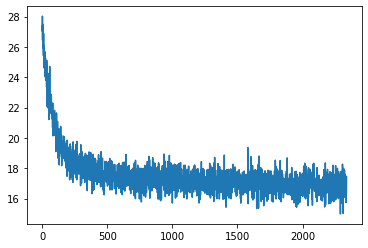

In [43]:
plt.figure()
plt.plot(losses)
plt.show()

In [44]:
i = 8000 # program we are testing
task = QuantumTask(i,lambda n_qubit, program=matched_programs[i]: dc.program.Program.parse(program[0]).evaluate([])(f_no_op(n_qubit)))
code =  dc.program.Program.parse(matched_programs[i][1])
embedding = recognition_model.featureExtractor.featuresOfTask(task)
predicted_grammar_of_task = recognition_model(embedding)
grammar.logLikelihood(code.infer(),code), predicted_grammar_of_task.logLikelihood(code.infer(),code)


(-29.1121815835177, tensor([-22.6289], grad_fn=<AddBackward0>))

In [45]:
print_circuit(dc.program.Program.parse(matched_programs[i][1]).evaluate([])(no_op(4)))
print_circuit(dc.program.Program.parse(matched_programs[i][0]).evaluate([])(f_no_op(4)))

     ┌───┐     ┌───┐               
q_0: ┤ H ├──■──┤ X ├───────────────
     ├───┤┌─┴─┐└─┬─┘┌───┐     ┌───┐
q_1: ┤ H ├┤ X ├──■──┤ H ├──■──┤ X ├
     ├───┤└───┘     └───┘┌─┴─┐└─┬─┘
q_2: ┤ H ├───────────────┤ X ├──■──
     └───┘               └───┘     
q_3: ──────────────────────────────
                                   
             ┌───┐        ┌───┐
q_0: ──■───X─┤ H ├──■───X─┤ H ├
     ┌─┴─┐ │ └───┘  │   │ └───┘
q_1: ┤ X ├─┼────────┼───X──────
     └───┘ │      ┌─┴─┐        
q_2: ──────X──────┤ X ├────────
                  └───┘        
q_3: ──────────────────────────
                               


In [48]:
task = get_task_from_name("cnot_10",tasks)
code = dc.program.Program.parse("(lambda (cnot (mv(minv( $0)))))")

embedding = recognition_model.featureExtractor.featuresOfTask(task)
predicted_grammar_of_task = recognition_model(embedding)

grammar.logLikelihood(code.infer(),code), predicted_grammar_of_task.logLikelihood(code.infer(),code)

(-8.317766166719343, tensor([-5.9396], grad_fn=<AddBackward0>))

In [47]:
task = get_task_from_name("swap_01",tasks)
code = dc.program.Program.parse("(lambda  (cnot(minv(mv_r(cnot(minv (mv (cnot  $0))))))))")

embedding = recognition_model.featureExtractor.featuresOfTask(task)
predicted_grammar_of_task = recognition_model(embedding)

grammar.logLikelihood(code.infer(),code), predicted_grammar_of_task.logLikelihood(code.infer(),code)

(-16.635532333438686, tensor([-21.4344], grad_fn=<AddBackward0>))

In [122]:
task = get_task_from_name("swap_0n",tasks)
code = dc.program.Program.parse("(lambda ((  (rep (dec(dec(size $0))) (lambda ((cnot(minv(mv_r(cnot(minv (mv (cnot(mv_r $0)))))))))) )  (mv_r( (rep (dec(size $0)) (lambda (mv((cnot(minv(mv_r(cnot(minv (mv (cnot $0)))))))))) )  $0 )))))")

embedding = recognition_model.featureExtractor.featuresOfTask(task)
predicted_grammar_of_task = recognition_model(embedding)

grammar.logLikelihood(code.infer(),code), predicted_grammar_of_task.logLikelihood(code.infer(),code)

(-56.838068805915505, tensor([-67.8985], grad_fn=<AddBackward0>))

In [183]:
task.logLikelihood(code)

0.0

In [536]:
def train():
    batch_size = 32
    n_steps = 1000

    gr.feature_extr.train();
    for _ in trange(n_steps):
        programs_batch = random.sample(matched_programs, batch_size)
        tasks_batch = [QuantumTask(i,lambda n_qubit, program=program: dc.program.Program.parse(program[0]).evaluate([])(f_no_op(n_qubit)))
                    for i, program in enumerate(programs_batch)]
        embedding = recognition_model.featureExtractor.featuresOfTasks(tasks_batch)
        simple_programs = [dc.program.Program.parse(program[1]) for program in programs_batch]
        contextual_grammar = dc.grammar.ContextualGrammar.fromGrammar(grammar)
        
        summaries = [contextual_grammar.closedLikelihoodSummary(simple_program.infer(), simple_program) for simple_program in simple_programs ]
        
        # if not using contextual grammar
        # summaries = [grammar.closedLikelihoodSummary(simple_program.infer(), simple_program) for simple_program in simple_programs ]

        optimizer.zero_grad()
        recognition_model.zero_grad()
        
        features = recognition_model._MLP(embedding)
        lls = recognition_model.grammarBuilder.batchedLogLikelihoods(features, summaries)
        loss = -lls.mean() 
        
        loss.backward()
        optimizer.step()
        losses.append(loss.data.item())

In [545]:
%load_ext line_profiler
%lprun -f gr.full_circuit_to_embeddings train()

  4%|▍         | 41/1000 [00:20<07:57,  2.01it/s]

*** KeyboardInterrupt exception caught in code being profiled.

Timer unit: 1e-06 s

Total time: 2.77232 s
File: /tmp/ipykernel_5224/1500948551.py
Function: full_circuit_to_embeddings at line 126

Line #      Hits         Time  Per Hit   % Time  Line Contents
   126                                               def full_circuit_to_embeddings(self, full_circuit):
   127      4032       7131.0      1.8      0.3          n_qubits, circuit = full_circuit
   128                                                   
   129      4032       6016.0      1.5      0.2          vertices = set()
   130      4032       3139.0      0.8      0.1          edges = set()
   131                                                   
   132                                                   # add aggregator vertex
   133      4032      19337.0      4.8      0.7          self.add_vertex(self.vertex_lexicon.index("aggregate"), self.vertex_kind_embeddings[n_qubits].num_embeddings-1, vertices)
   134                                           
   135      4032      45828.0     11.4

In [ ]:
# - Try to merge two low-level programs and see if we find one solution in the full

In [1]:
# - X Split training/test dataset
# - X Fix dataset augmentation by removing EMBED gate when not needed
# - X Fix graph generation with aggregator edges (all vertices connected to AGGREGATOR!)
# - X Masking to allow batch processing (1=masked, 0=allowed)
# - Refactor notebook

In [ ]:
[v["task"] for v in restricted_dictionary.values()], len(restricted_dictionary)
[v["task"] for v in full_dictionary.values()], len(full_dictionary)

In [ ]:
dc.great.Great(layers=4,batch_first=True)(torch.rand(9,5,512),
                        torch.rand(9,5,5,512),torch.rand(9,5)>0.5 )

# check output batched with mask and not batched
# SHOULD the edge relation matrix be symmetric?

tensor([[[ 2.2759, -0.9362, -0.9602,  ...,  0.6412,  0.4378, -0.7729],
         [ 1.7919, -0.6928, -0.9339,  ...,  0.8708,  1.3383, -1.1959],
         [ 1.2987, -0.6996,  0.0477,  ...,  0.3061,  1.1436, -1.6745],
         [ 1.2819,  0.2977, -1.0037,  ...,  0.4054,  1.5640, -0.7430],
         [ 1.7916,  0.0230, -0.8343,  ...,  1.0366,  1.3168, -1.8804]],

        [[ 2.0887, -0.1400,  0.0943,  ...,  0.9963,  1.7624, -2.4135],
         [ 1.4391,  0.5386, -0.4229,  ...,  2.0502,  1.9189, -1.3506],
         [ 1.6665,  0.8416,  1.2304,  ...,  0.8859,  0.6563, -2.1701],
         [ 1.5891, -0.5968, -0.0885,  ...,  1.3230,  0.4269, -0.0181],
         [ 1.8056,  0.2443, -1.2259,  ...,  0.9780,  0.1213, -0.8895]],

        [[ 0.8442,  0.1006,  0.0183,  ...,  1.8837,  0.5749, -0.5465],
         [ 2.5495, -0.1414,  0.4686,  ...,  1.7190,  1.0287, -1.3964],
         [ 1.8204, -0.5687,  0.1718,  ...,  0.3555,  1.1992, -1.9379],
         [ 0.5032, -0.4394,  0.1243,  ...,  0.9252,  0.4069, -1.3862],
  